In [2]:
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import time
from datetime import datetime

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

consumer_key = "xpDldnAQyAyNBuoK08TiiiOgX"
consumer_secret = "KXxscYkr2tV5e4eqDsvVHz848eeFOFg6aMaYLA9y46PfHbtHtq"
access_token = "948782412078530560-EQLSb1bqkYNa0xVEaR1CddGObN2uNHj"
access_token_secret = "FK7SjBHhXXWCWWmJ7yWat1D0a25ROI1CfI65b54w5R3cK"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [23]:
# Target Search Term
target_terms = ("@OPECnews", "@Shell", "@exxonmobil", "@Chevron", "@conocophillips", "@OXY_Petroleum", 
                "@ValeroEnergy", "@Phillips66Co", "@MarathonPetroCo", "@DevonEnergy")

# "Real Person" Filters
min_tweets = 5
max_tweets = 10000
max_followers = 2500
max_following = 2500
lang = "en"

# Array to hold sentiment
sentiments = []

# Loop through all target users
for target in target_terms:
    
    # Defining a counter
    counter = 1

    # Loop through 15 times
    for x in range(15):

        # Run search around each tweet
        public_tweets = api.search(target, count=100, result_type="recent")

        # Loop through all tweets
        for tweet in public_tweets["statuses"]:
            
            # Use filters to check if user meets conditions
            if (tweet["user"]["followers_count"] < max_followers and
                    tweet["user"]["statuses_count"] > min_tweets and
                    tweet["user"]["statuses_count"] < max_tweets and
                    tweet["user"]["friends_count"] < max_following and
                    tweet["user"]["lang"] == lang):

                # Run Vader Analysis on each tweet
                compound = analyzer.polarity_scores(tweet["text"])["compound"]
                pos = analyzer.polarity_scores(tweet["text"])["pos"]
                neu = analyzer.polarity_scores(tweet["text"])["neu"]
                neg = analyzer.polarity_scores(tweet["text"])["neg"]
                tweets_ago = counter
                
                # Conversion of actual timestamp
                raw_time = tweet["created_at"]
                converted_time = datetime.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y")
                time_format = converted_time.strftime("%Y-%m-%d")
                
                # Store all the sentiments
                try:
                    sentiments.append({"Source Account": tweet['entities']['user_mentions'][0]['name'],
                                       "Media Sources": target,
                                       "Actual Date": tweet["created_at"],
                                       "Date": time_format,
                                       "Tweet Polarity": compound,
                                       "Positive": pos,
                                       "Neutral": neu,
                                       "Negative": neg,
                                       "Tweets Ago": counter})
                except:
                    continue

                # Add to counter 
                counter = counter + 1

In [26]:
sentiments_pd = pd.DataFrame(sentiments)
len(sentiments_pd)

4980

In [27]:
sentiments_pd.head()

,Actual Date,Date,Media Sources,Negative,Neutral,Positive,Source Account,Tweet Polarity,Tweets Ago
0,Fri Jan 19 07:34:06 +0000 2018,2018-01-19,@OPECnews,0.13,0.87,0.0,KEC International,-0.1280,1
1,Fri Jan 19 03:38:06 +0000 2018,2018-01-19,@OPECnews,0.00,1.00,0.0,OPEC News,0.0000,2
2,Fri Jan 19 01:24:42 +0000 2018,2018-01-19,@OPECnews,0.16,0.84,0.0,Export-Import Bank,-0.2263,3
3,Thu Jan 18 21:18:09 +0000 2018,2018-01-18,@OPECnews,0.00,1.00,0.0,Boason Omofaye,0.0000,4
4,Thu Jan 18 13:53:43 +0000 2018,2018-01-18,@OPECnews,0.00,1.00,0.0,Bob McNally,0.0000,5


In [28]:
sentiments_pd.to_csv("/Users/manoranjanpemmaka/Downloads/Oil_Company_Tweet_Data_011918.csv")

In [34]:
sentiments_groupby = sentiments_pd.groupby(['Date', 'Media Sources'])
sentiments_mean = sentiments_groupby['Tweet Polarity'].mean()
sentiments_final = pd.DataFrame(sentiments_mean).reset_index()
len(sentiments_final)

65

In [44]:
sentiments_final.head()

,Date,Media Sources,Tweet Polarity
0,2018-01-09,@DevonEnergy,0.438900
1,2018-01-09,@MarathonPetroCo,0.733000
2,2018-01-09,@OPECnews,0.000000
3,2018-01-09,@OXY_Petroleum,0.035744
4,2018-01-09,@Phillips66Co,0.180600


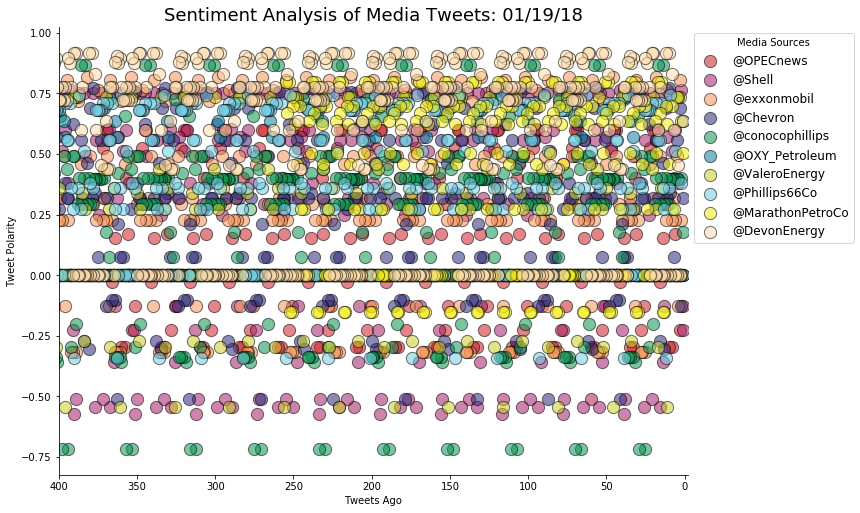

In [49]:
#create lmplot using seasborn

#set colorlist for charts
clrlist = ["#cb2028", "#a2206a", "#f79459", "#2d2a7b", "#0e9553", "#0b81a1", "#cccd2a", 
           "#72cee3", "#f3ec18", "#fedbab", "#cd8d2b"]
#clrlist = ["#82acf9", "#e00b0b"]

#sns.set_palette(clrlist)
sns.color_palette(clrlist)

#create chart
MediaTweetAnalysis = sns.lmplot(x="Tweets Ago", y="Tweet Polarity", data=sentiments_pd, 
           hue="Media Sources", size=7, aspect=1.4,
           legend_out=False, legend=True, 
           scatter_kws={"s":150, 'alpha':.55, 'edgecolors':"black", 'linewidth':1}, 
                                fit_reg=False, palette=clrlist)
plt.xlim(400,-2)
plt.title("Sentiment Analysis of Media Tweets: %s" % time.strftime('%x'), fontsize=18)
plt.legend(bbox_to_anchor=(1, 1), ncol=1, title="Media Sources", fontsize=12)
#plt.savefig("Sentiment_Analysis_of_Media_Tweets.png", bbox_inches='tight')
plt.show(MediaTweetAnalysis)